In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score
from pygooglechart import PieChart3D

In [3]:
kolumny = ['Age', 'Job', 'Marital', 'Education', 'Default', \
           'Housing', 'Personal_loan', 'Contact', 'Month','Day_of_week', 'Duration', \
           'Campaign', 'Pdays', 'Previous', 'Poutcome','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed', 'Target']

kolumny_kategoryczne = ['Job','Marital','Education','Default','Housing','Personal_loan','Contact','Month','Day_of_week','Poutcome']
kolumny_numeryczne = ['Age','Duration','Pdays','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed','Campaign','Previous']

data = pd.read_csv('/Users/Lukas/Downloads/bank-additional-full.csv', sep=';', names=kolumny, header=1)

# sprawdzamy czy są braki danych
data.isnull().any()
data[data[:]=='unknown'].count()

Y = pd.DataFrame()
X = pd.DataFrame()
Y['Target'] = data['Target']
#print(Y)
X = data.drop(['Target'], 1)
#print(X)

# Check target values balance
print(f"Target value counts \n{Y['Target'].value_counts()}")
yes = len(Y[Y['Target'] == 'yes'])/ len(Y)
print(f"Percentage of 'yes' answer: {yes}")
print(f"Percentage of 'no' answer: {1-yes}")
data.shape


Target value counts 
no     36547
yes     4640
Name: Target, dtype: int64
Percentage of 'yes' answer: 0.11265690630538762
Percentage of 'no' answer: 0.8873430936946124


/usr/local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


(41187, 21)

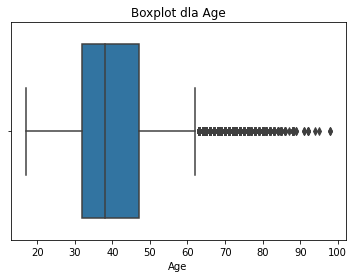

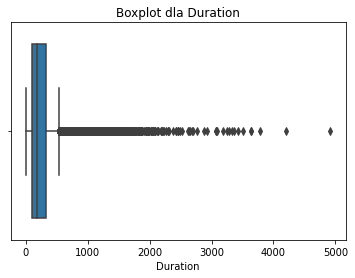

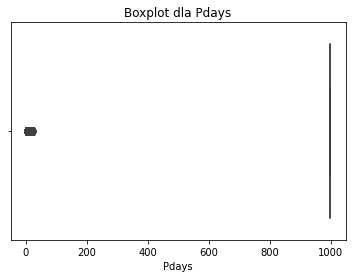

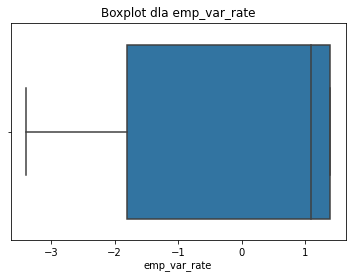

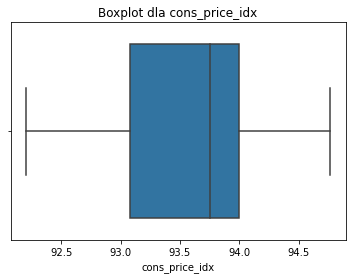

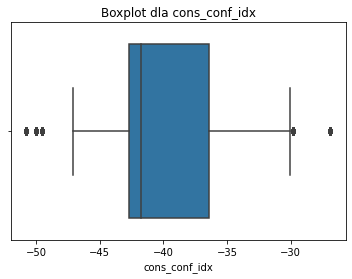

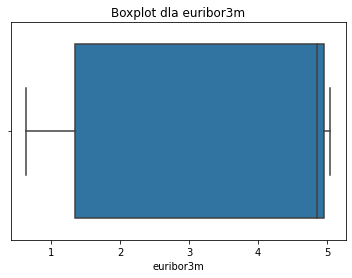

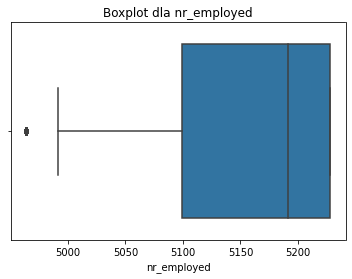

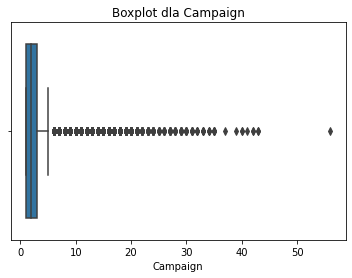

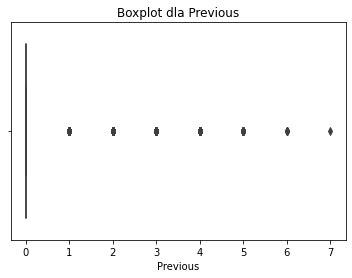

Kolumna: Job, Liczba nieznanych:  330
Kolumna: Marital, Liczba nieznanych:  80
Kolumna: Education, Liczba nieznanych:  1731
Kolumna: Default, Liczba nieznanych:  8597
Kolumna: Housing, Liczba nieznanych:  990
Kolumna: Personal_loan, Liczba nieznanych:  990
Kolumna: Contact, Liczba nieznanych:  0
Kolumna: Month, Liczba nieznanych:  0
Kolumna: Day_of_week, Liczba nieznanych:  0
Kolumna: Poutcome, Liczba nieznanych:  0


' odstające dla:\n    -Age\n    -Duration (zmienna ostatecznie usuwana)\n    -Pdays (wartości odstające tj. wartość 999, odnoszą się do osób które wcześniej nie były kontaktowane)\n    -cons_conf_idx\n    -nr_employed\n    -Campaign\n    -Previous\n'

In [4]:
# Box ploty dla numerycznych

# for col in kolumny_numeryczne:
#     plt.boxplot(data[col])
#     plt.title("Boxplot dla "+col)
#     plt.savefig('box_ploty/' + col + "_box.png")
#     plt.show()
for col in kolumny_numeryczne:
    sns.boxplot(data[col], whis=1)
    plt.title("Boxplot dla "+col)
    #plt.savefig('box_ploty/' + col + "_box.png")
    plt.show()

# zliczanie pustych komórek dla poszczegolnych kolumn
for col in kolumny_kategoryczne:
    count = data[data[col]=='unknown'][col].count()
    print(f'Kolumna: {col}, Liczba nieznanych: ', count)
""" odstające dla:
    -Age
    -Duration (zmienna ostatecznie usuwana)
    -Pdays (wartości odstające tj. wartość 999, odnoszą się do osób które wcześniej nie były kontaktowane)
    -cons_conf_idx
    -nr_employed
    -Campaign
    -Previous
"""

In [5]:
# Answers mapping 0 - no, 1 - yes
answer_mapping = {"no": 0, "yes": 1}

data['Target'] = data['Target'].map(answer_mapping)


In [6]:
data['Target'].value_counts()

0    36547
1     4640
Name: Target, dtype: int64

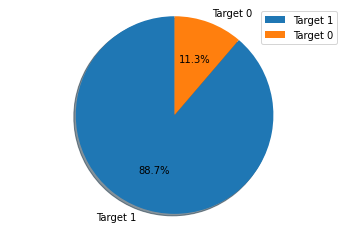

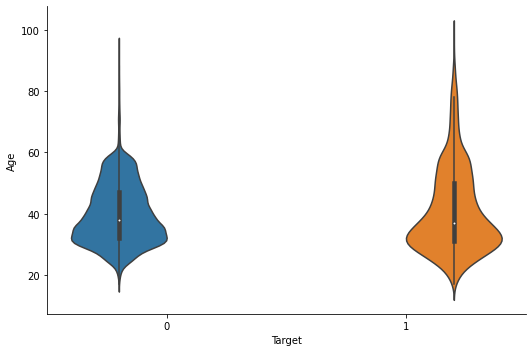

In [29]:

data['Target']
#target balance

labels = ['Target 1', 'Target 0']

fig1, ax1 = plt.subplots()
ax1.pie(data['Target'].value_counts(), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()


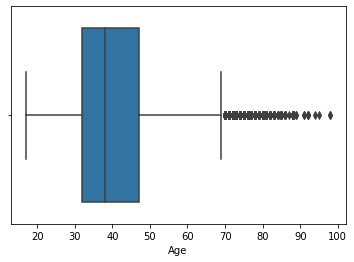

count    41187.000000
mean        40.023673
std         10.421079
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: Age, dtype: float64

In [17]:
# Wiek
sns.boxplot(data['Age'])
plt.show()
data['Age'].describe()

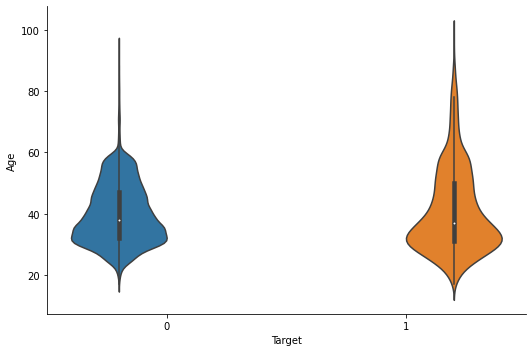

In [30]:
sns.catplot(x='Target', y='Age',kind='violin', hue='Target',data=data, aspect=1.5)

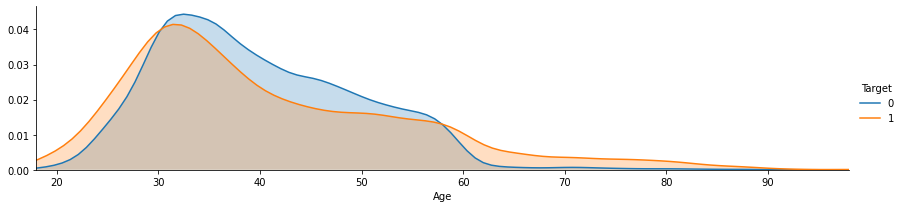

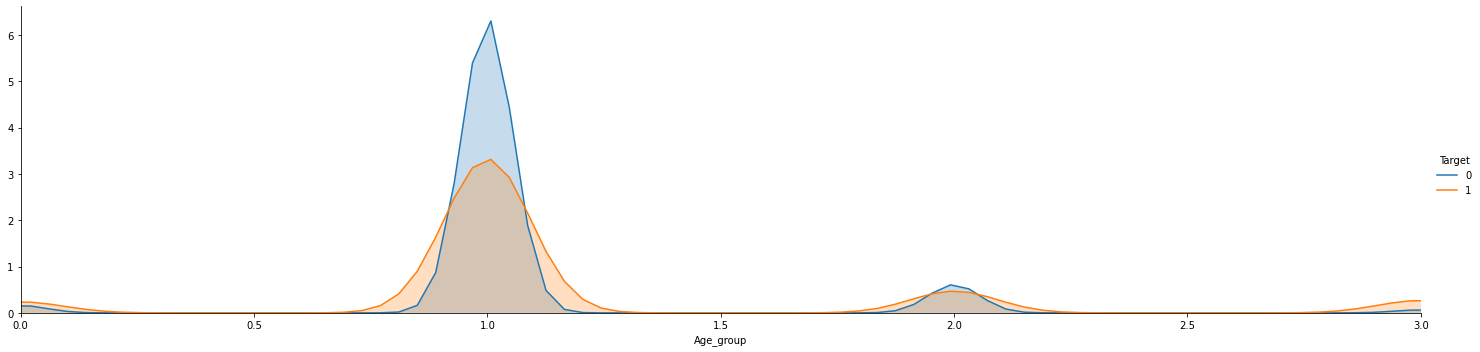

In [33]:
# kernel density plot
facet = sns.FacetGrid(data, hue="Target", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True, bw=.15)
facet.set(xlim=(18, data['Age'].max()))

facet.add_legend()

# age grouping  
conditions = [(data['Age']<=24), ((data['Age']>24) & (data['Age']<=54)), ((data['Age']>=55)& (data['Age']<66)), (data['Age']>=66)]
labels = [0,1,2,3]
data['Age_group'] = np.select(conditions, labels)
data['Age_group']
facet = sns.FacetGrid(data, hue='Target', aspect = 4, height=5)
facet.map(sns.kdeplot, 'Age_group', shade = True, bw=.15)
facet.set(xlim=(0, data['Age_group'].max()))
facet.add_legend()
plt.show()

69.5
221
248
469


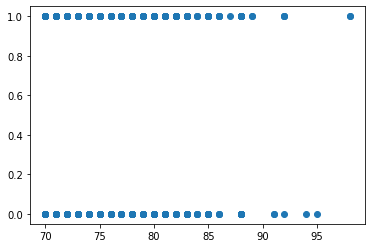

In [31]:
# Wiek - zamiana wartości odstających
was_gorny = data['Age'].quantile(0.75)+1.5*(data['Age'].quantile(0.75)-data['Age'].quantile(0.25))
print(was_gorny)
print(data.loc[((data['Age']>69.5)&(data['Target']==1)),'Age'].count())
print(data.loc[((data['Age']>69.5)&(data['Target']==0)),'Age'].count())
print(data.loc[data['Age']>69.5,'Age'].count())
plt.scatter(x=data.loc[data['Age']>69,'Age'],y=data.loc[data['Age']>69,'Target'])



In [38]:
# zamiana wartosci odstajacych na wąsy
#data.loc[data['Age']>69,'Age'] = 69

In [42]:
# Mapping Marital
print(data['Marital'].value_counts())

data = pd.concat([data, pd.get_dummies(data['Marital'])], axis=1)

data.rename(columns={'unknown': 'Marital_unk'}, inplace=True)



married     24927
single      11568
divorced     4612
unknown        80
Name: Marital, dtype: int64


In [34]:
conditions = [(data['Marital']=='married'),(data['Marital']=='single'),(data['Marital']=='divorced'),(data['Marital']=='unknown')]
labels = [0,1,2,3]
data['Marital_group'] = np.select(conditions,labels)

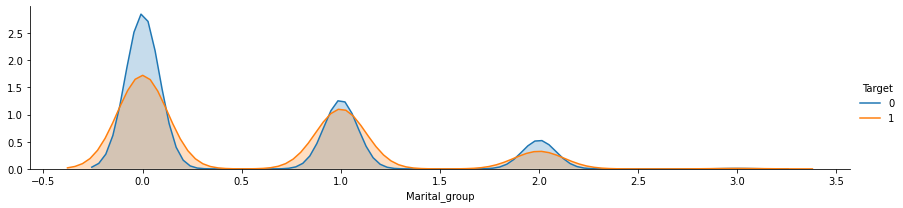

In [35]:
facet = sns.FacetGrid(data,hue = 'Target', aspect=4)
facet.map(sns.kdeplot,'Marital_group',shade = True)
facet.add_legend()
plt.show()
# mozemy wnioskować, że osoby ze statusem 'married' wykazują mniejszą skłonność do skorzystania z lokaty terminowej

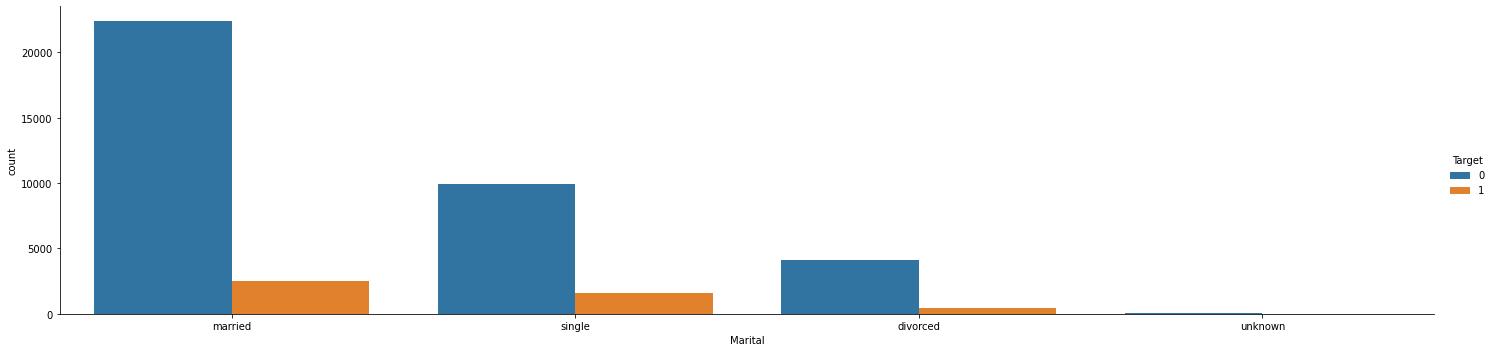

In [44]:
sns.catplot('Marital', kind='count',data = data, hue='Target', aspect=4)

-36.4    7762
-42.7    6685
-46.2    5794
-36.1    5175
-41.8    4374
-42.0    3616
-47.1    2458
-31.4     770
-40.8     715
-26.9     447
-30.1     357
-40.3     311
-37.5     303
-50.0     282
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     204
-33.6     178
-34.6     174
-33.0     172
-50.8     128
-40.4      67
-45.9      10
Name: cons_conf_idx, dtype: int64


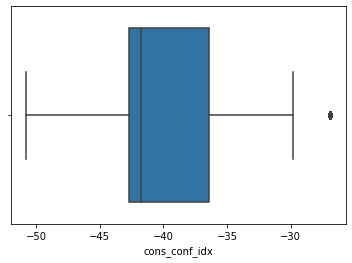

In [45]:
# Cons_conf_idx
print(data.cons_conf_idx.value_counts())
sns.boxplot(data['cons_conf_idx'])
plt.show()


In [46]:
print(data['cons_conf_idx'].quantile(0.75)+1.5*(data['cons_conf_idx'].quantile(0.75)-data['cons_conf_idx'].quantile(0.25)))


-26.949999999999992


In [47]:
def cat_to_int(column):
    uniques = data[column].unique()
    new_col_name = column + '_group'
    conditions = []
    labels = []
    for i in range(len(uniques)):
        conditions.append((data[column]==uniques[i]))
        labels.append(i)
    data[new_col_name] = np.select(conditions, labels)
    return data[new_col_name]
cat_to_int('Month')

0        0
1        0
2        0
3        0
4        0
        ..
41182    5
41183    5
41184    5
41185    5
41186    5
Name: Month_group, Length: 41187, dtype: int64

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4175
basic.6y                2292
unknown                 1731
illiterate                18
Name: Education, dtype: int64
['high.school' 'basic.6y' 'basic.9y' 'professional.course' 'unknown'
 'basic.4y' 'university.degree' 'illiterate']


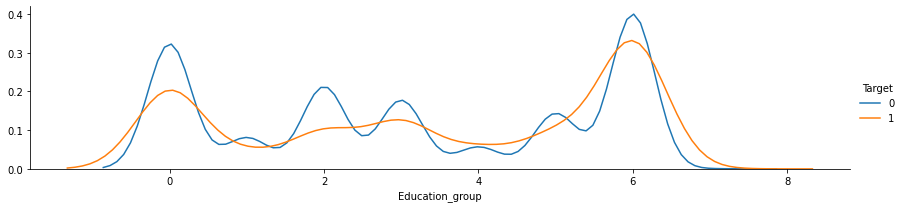

In [48]:
# Edukacja
print(data['Education'].value_counts())
print(data['Education'].unique())
cat_to_int('Education')
facet = sns.FacetGrid(data, hue='Target',aspect = 4)
facet.map(sns.kdeplot,'Education_group')
facet.add_legend()
plt.show()

In [49]:
# Czy podstawowa edukacja
data['if_basic_educ'] = 0
data.loc[data['Education'].isin(['basic.4y','basic.6y','basic.9y']),'if_basic_educ'] = 1

print(data['if_basic_educ'].value_counts())

data = pd.concat([data, pd.get_dummies(data['Education'])], axis=1)

0    28675
1    12512
Name: if_basic_educ, dtype: int64


In [50]:
# Default - problemy z kredytem
###### powinno być usunięte, powielane są informacje ze zmiennej default
print(data['Default'].value_counts())

#data['if_no_default'] = 0
#data.loc[data['Default']=='no', 'if_no_default'] = 1

no         32587
unknown     8597
yes            3
Name: Default, dtype: int64


In [51]:
# Housing - kredyt mieszkaniowy
housing_mapping = {'no': 0, 'yes':1, 'unknown': np.nan}

data['Housing'] = data['Housing'].map(housing_mapping)

In [52]:
# Personal loan - pozyczka
personal_loan_mapping = {'no': 0, 'yes':1, 'unknown':np.nan}

data['Personal_loan'] = data['Personal_loan'].map(personal_loan_mapping)

# If_no_loan - jesli nie ma kredytu

data['if_no_loan'] = 0
data.loc[(data['Housing']==0) & (data['Personal_loan']==0),'if_no_loan']=1
print(data['if_no_loan'].value_counts())


# if_both_loan - jesli ma obydwa kredyty (housing i personal)

data['if_both_loan'] = 0
data.loc[(data['Housing']==1) & (data['Personal_loan']==1),'if_both_loan']=1
print(data['if_both_loan'].value_counts())

0    25123
1    16064
Name: if_no_loan, dtype: int64
0    37496
1     3691
Name: if_both_loan, dtype: int64


In [53]:
# Contact - Kontakt
contact_mapping = {'telephone': 0, 'cellular':1}

data['Contact'] = data['Contact'].map(contact_mapping)

In [54]:
# Zawody na binarne

data = pd.concat([data, pd.get_dummies(data['Job'])], axis=1)

In [ ]:
# Miesiące na binarne

data = pd.concat([data, pd.get_dummies(data['Month'])], axis=1)

# Kwartały
'''
data['quartile']=0
data.loc[data['Month'].isin(['jan','feb','mar']), "quartile"] = 'qr_1',
data.loc[data['Month'].isin(['apr','may','jun']), "quartile"] = 'qr_2',
data.loc[data['Month'].isin(['jul','aug','sep']), "quartile"] = 'qr_3',
data.loc[data['Month'].isin(['oct','nov','dec']), "quartile"] = 'qr_4'
print(data['quartile'].value_counts())

data = pd.concat([data, pd.get_dummies(data['quartile'])], axis=1)
'''
# Wakacje

data['if_holidays'] = 0
data.loc[data['Month'].isin(['jul','aug']),'if_holidays']=1
print(data['if_holidays'].value_counts())

In [ ]:
# Dzien tygodnia

data = pd.concat([data, pd.get_dummies(data['Day_of_week'])], axis=1)

In [ ]:
# jeśli był kontaktowany w tej kampanii

data['if_contact_this_camp'] = 0
data.loc[data['Campaign']>1,'if_contact_this_camp'] = 1
print(data['if_contact_this_camp'].value_counts())

In [ ]:
# Outliers dla kampanii
data['Campaign'].quantile(0.95)
data.loc[data['Campaign']>7, 'Target'].value_counts()
data.loc[data['Campaign']>7,'Campaign'] = 7

In [ ]:
# jesli byl kiedykolwiek kontaktowany podczas poprzedniej kampanii

data['if_contact_prev'] = 0
data.loc[data['Pdays'] != 999, 'if_contact_prev'] = 1
print(data['if_contact_prev'].value_counts())

In [ ]:
# jesli byl kontaktowany poza aktualna i poprzednia kamapania
data.loc[(data['if_contact_prev']==0) & (data['Previous']>0),'Previous'].value_counts()
data['if_contact_no_camp'] = 0
data.loc[(data['if_contact_prev']==0) & (data['Previous']>0), 'if_contact_no_camp'] = 1

In [ ]:
# Rezultat poprzedniej kampanii
data = pd.concat([data, pd.get_dummies(data['Poutcome'])], axis=1)

In [ ]:
def bar_chart(feature):
    accepted = data[data['Target'] == 1][feature].value_counts()
    declined = data[data['Target'] == 0][feature].value_counts()
    df = pd.DataFrame([accepted, declined])
    df.index = ['Accepted', 'Declined']

    df.plot(kind='bar', stacked='True', figsize=(10, 10))
    plt.title(feature)
    plt.savefig('Diagrams/' + feature + "_Diagram.png")
    plt.show()

In [ ]:
def sns_plot(feature, max=0, min=0):
    facet = sns.FacetGrid(data, hue="Target", aspect=4)
    facet.map(sns.kdeplot, feature, shade=True, bw=.15)
    facet.set(xlim=(0, data[feature].max()))
    facet.add_legend()
    if max == 0:
        max = data[feature].max()
    if min == 0:
        min = data[feature].min()
    plt.xlim(min, max)

    #plt.savefig('Diagrams/' + feature + "_Diagram.png")
    plt.show()

In [ ]:
sns_plot('Age')

In [ ]:
def roc_curve(model,filename,y_train, y_test, model_name):

    # Train data
    pred_prob_tr = model.predict_proba(train_test_data[0])
    preds_tr = pred_prob_tr[:, 1]
    fpr_tr, tpr_tr, treshold_tr = metrics.roc_curve(y_train, preds_tr)
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)

    # Test data
    pred_prob = model.predict_proba(train_test_data[1])
    preds = pred_prob[:,1]
    fpr, tpr, treshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='Test Data (AUC =%0.2f)' % roc_auc)
    plt.plot(fpr_tr, tpr_tr, label='Train Data (AUC=%0.2f)'%roc_auc_tr)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve {model_name}')
    plt.savefig(f'Diagrams/{filename}')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# grupowanie po wieku
# for dataset in train_test_data:
#     dataset.loc[dataset['Age']<30, 'Age'] = 0,
#     dataset.loc[(dataset['Age']>=30) & (dataset['Age']<60),'Age'] = 1,
#     dataset.loc[dataset['Age']>=60, 'Age']=2

print(data['Age'].value_counts())
# tworzenie wykresów dla zmiennych kategorycznych
# for col in kolumny_kategoryczne:
#     bar_chart(col)
#
# sns_plot('Age',2.5,1.5)

In [ ]:
# kolumny print
print(data.columns)

print(data.shape)

In [ ]:
# Przygotowanie danych do modelowania
data = data.drop('Duration', axis=1)
data = data.drop('Job', axis=1)
#data = data.drop('quartile', axis=1)
data = data.drop('Month', axis=1)
data = data.drop('Education', axis=1)
data = data.drop('Marital', axis=1)
data = data.drop('Day_of_week', axis=1)
data = data.drop('Poutcome', axis=1)
data = data.drop('nonexistent', axis=1)
data = data.drop('Marital_unk', axis=1)
data = data.drop('unknown', axis=1)
data = data.drop('Default', axis=1)
data = data.drop('Pdays', axis=1)

In [ ]:
cole = []
for col in data.columns:
    cole.append(col)

imputer = KNNImputer(n_neighbors=21)
data = pd.DataFrame(imputer.fit_transform(data),columns=cole)
data['Housing'] = round(data['Housing'])
data['Personal_loan'] = round(data['Personal_loan'])
print(data.isnull().sum(axis=0))

In [ ]:
# Normalizacja
def Normalize(data):

    x = data.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    data = pd.DataFrame(x_scaled, columns=cole)
    return data

# Normalizacja
data = Normalize(data)

In [ ]:
# Tabela ze wszystkimi rekordami
data.to_csv('full_data_normalized.csv')

Y = pd.DataFrame()
X = pd.DataFrame()
Y['Target'] = data['Target']
print(Y)
X = data.drop(['Target'], 1)
print(X)

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.4, random_state=101)
train = pd.concat([x_train, y_train], axis=1, sort=False)
test = pd.concat([x_test, y_test], axis=1, sort=False)
train_test_data = [train, test]
target_train = train_test_data[0]['Target']
target_test = train_test_data[1]['Target']
train_test_data[0] = train_test_data[0].drop('Target', axis=1)
train_test_data[1] = train_test_data[1].drop('Target', axis=1)
print(train.columns)

print(train_test_data[0]['euribor3m'].describe())

print(train_test_data[0].shape)
print(train_test_data[0].dtypes)


cole = []
for col in train_test_data[0].columns:
    cole.append(col)

In [ ]:
# KNN IMPUTER
for dataset in train_test_data:
    print(dataset.dtypes)
# imputer = KNNImputer(n_neighbors=21)
# train_test_data[0] = pd.DataFrame(imputer.fit_transform(train_test_data[0]),columns=cole)
# train_test_data[1] = pd.DataFrame( imputer.fit_transform(train_test_data[1]),columns=cole)
# for dataset in train_test_data:
#     dataset['Housing'] = round(dataset['Housing'])
#     dataset['Personal_loan'] = round(dataset['Personal_loan'])

print(train_test_data[0].isnull().sum(axis=0))
print(train_test_data[1].isnull().sum(axis=0))
train_test_data[0].to_csv('trainx.csv')
train_test_data[1].to_csv('trainxxx.csv')

In [ ]:
print(train_test_data[0].columns)

In [ ]:
## TO CSV
train_test_data[0].to_csv('train.csv')
train_test_data[1].to_csv('test.csv')
# DO SAS'a
train_sas = pd.concat([train_test_data[0], target_train], axis=1)
train_sas.to_csv('train_sas.csv')
test_sas = pd.concat([train_test_data[1], target_test], axis=1)
test_sas.to_csv('test_sas.csv')

In [ ]:
# Regresja logistyczna

grid=[ {"C":np.logspace(-3,3,7), "penalty":['l1'], 'solver':[ 'liblinear','saga']},
       {"C":np.logspace(-3,3,7), "penalty":['l2'], 'solver':['lbfgs','newton-cg', 'sag']}]# l1 lasso l2 ridge
# # WALIDACJA KRZYŻOWA
# reg = LogisticRegression(max_iter= 10000)
# reg_cv=GridSearchCV(reg,grid,cv=3, n_jobs=1)
# reg_cv.fit(train_test_data[0], target_train)
#
#
# print("accuracy :",reg_cv.best_score_)
# print("tuned hpyerparameters :(best parameters) ",reg_cv.best_params_)
#
#
# print(reg_cv.predict(train_test_data[1]))
# print("Logistic regression score: ", reg_cv.score(train_test_data[1], target_test)*100,"%")


reg = LogisticRegression(C=10, penalty='l1',solver='saga',max_iter= 10000)
reg.fit(train_test_data[0],target_train)
print("Logistic regression score: ", reg.score(train_test_data[1], target_test)*100,"%")
print("Logistic regression coefficients: ", reg.coef_)
preds = reg.predict(train_test_data[1])
np.savetxt('logistic_preds.csv',reg.predict_proba(train_test_data[1]),delimiter=';')
print("Macierz trafien: ",confusion_matrix(target_test, preds))
roc_curve(reg,"ROC_REG",target_train,target_test,"REG")
skplt.metrics.plot_lift_curve(target_test,reg.predict_proba(train_test_data[1]))
plt.show()

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='auto', min_samples_split=0.1, max_leaf_nodes=16, random_state=72 )
clf.fit(train_test_data[0], target_train)

print("Decision tree score: ", clf.score(train_test_data[1], target_test))
preds = clf.predict(train_test_data[1])
np.savetxt('decision_tree_preds.csv',clf.predict_proba(train_test_data[1]),delimiter=';')
print("Macierz trafien: ",confusion_matrix(target_test, preds))
export_graphviz(clf,out_file='Diagrams/DecisionTree.dot',class_names=True, label='all',
                      rounded=True, filled = True)
roc_curve(clf,"ROC_CLF",target_train,target_test,"CLF")
skplt.metrics.plot_lift_curve(target_test,clf.predict_proba(train_test_data[1]))
plt.show()

In [ ]:
# K NEAREST NEIGHBOURS

grid_knn = [{'n_neighbors':np.arange(2,30),'weights':['uniform','distance'], 'algorithm':['ball_tree','kd_tree','brute'],'leaf_size':[50,40,20,15],'p':[1,2]}]
knn = KNeighborsClassifier(n_jobs=10)
knn_cv = GridSearchCV(knn,grid_knn, cv=3)
knn_cv.fit(train_test_data[0],target_train)
print("accuracy :",knn_cv.best_score_)
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)

cv_scores = []

knn = KNeighborsClassifier(n_neighbors=50, n_jobs = 10, weights='uniform', p=1, algorithm='ball_tree', leaf_size=50)
knn.fit(train_test_data[0], target_train)


print("KNN score: ", knn.score(train_test_data[1], target_test))
preds = knn.predict(train_test_data[1])
np.savetxt('knn_preds.csv',knn.predict_proba(train_test_data[1]),delimiter=';')
print("Macierz trafien: ",confusion_matrix(target_test, preds))

roc_curve(knn,"ROC_KNN",target_train,target_test,"KNN")
skplt.metrics.plot_lift_curve(target_test,knn.predict_proba(train_test_data[1]))
plt.show()

In [ ]:
########

from sklearn import metrics
fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

probs = clf.predict_proba(train_test_data[1])
preds = probs[:,1]
fprgbk, tprgbk, thresholdgbk = metrics.roc_curve(target_test, preds)
roc_aucgbk = metrics.auc(fprgbk, tprgbk)

ax1.plot(fprgbk, tprgbk, 'b', label = 'AUC = %0.2f' % roc_aucgbk)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic Decision Tree ',fontsize=10)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})

plt.subplots_adjust(wspace=1)